## Imports

In [2]:
pip install pyccel

     |████████████████████████████████| 350 kB 19.4 MB/s 
     |████████████████████████████████| 74 kB 4.2 MB/s 
     |████████████████████████████████| 54 kB 3.8 MB/s 


In [3]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

import time
from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

## Pure python function

In [4]:
def solve_2d_diff_pure(u, un, nt, dt, dx, dy, nu):
    row, col = u.shape
    
    ###Assign initial conditions
    # set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2
    
    #fill the update of u
    for n in range(nt):
        for i in range (row):
            for j in range(col):
                un[i,j] = u[i,j]
        for i in range(1, row-1):
            for j in range(1,col-1):
                u[i,j] = un[i,j] + (nu * dt / (dx**2)) * (u[i+1,j]-(2*un[i,j]) + un[i-1,j]) + (nu * dt / (dy**2)) * (u[i,j+1]-(2*un[i,j]) + un[i,j-1])
                
        
    return 0

## Numba accelerator

In [5]:
#add the numba decorator to accelerate code
@njit(fastmath=True)
def solve_2d_diff_numba(u, un, nt, dt, dx, dy, nu):
    row, col = u.shape
    
    ###Assign initial conditions
    # set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2
    
    
    #fill the update of u
    for n in range(nt):
        for i in range (row):
            for j in range(col):
                un[i,j] = u[i,j]
        for i in range(1, row-1):
            for j in range(1,col-1):
                u[i,j] = un[i,j] + (nu * dt / (dx**2)) * (u[i+1,j]-(2*un[i,j]) + un[i-1,j]) + (nu * dt / (dy**2)) * (u[i,j+1]-(2*un[i,j]) + un[i,j-1]) 
        
    return 0

## Pyccel accelerator

In [6]:
def solve_2d_diff_pyccel(u: 'float[:,:]', un:'float[:,:]', nt :'int', dt:'float', dx:'float', dy:'float', nu:'float'):
    row, col = u.shape
    
    ##Assign initial conditions
    #set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2
    
    
    #fill the update of u 
    for n in range(nt):
        for i in range (row):
            for j in range(col):
                un[i,j] = u[i,j]
        for i in range(1, row-1):
            for j in range(1,col-1):
                u[i,j] = un[i,j] + (nu * dt / (dx**2)) * (u[i+1,j]-(2*un[i,j]) + un[i-1,j]) + (nu * dt / (dy**2)) * (u[i,j+1]-(2*un[i,j]) + un[i,j-1])
        
    return 0

## Inputs

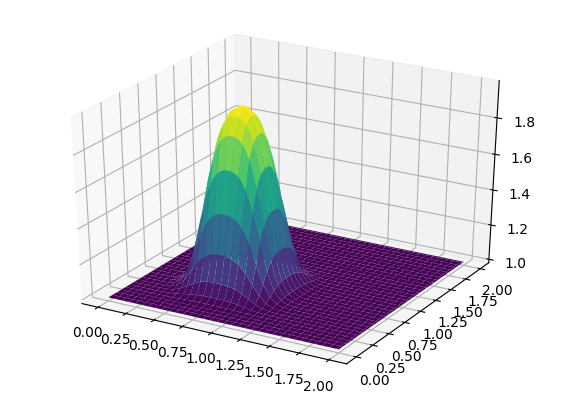

In [7]:
###variable declarations
nt = 51
nx = 101
ny = 101
nu = .05
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .25
dt = sigma * dx * dy / nu

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u = np.ones((ny, nx))  # create a 1xn vector of 1's
un = np.ones((ny, nx))

u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 
u = u.copy()
un = np.ones((ny, nx)) 


solve_2d_diff_pure(u, un, nt, dt, dx, dy, nu)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u, cmap=cm.viridis)

## Call Funtions

### Pure function

In [8]:
%timeit solve_2d_diff_pure(u, un, nt, dt, dx, dy, nu)

1 loop, best of 5: 1.38 s per loop


### Function with numba accelerator

In [9]:
%timeit solve_2d_diff_numba(u, un, nt, dt, dx, dy, nu)

The slowest run took 496.49 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 1.31 ms per loop


### Function with pyccel accelerator

In [10]:
solve_2d_diff_f90 = epyccel(solve_2d_diff_pyccel)

In [11]:
%timeit solve_2d_diff_f90(u, un, nt, dt, dx, dy, nu)

1000 loops, best of 5: 1.26 ms per loop
